In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cluster
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.linear_model
import sklearn.model_selection
import torch

In [2]:
data = pd.read_csv('data.csv')

In [3]:
y=data['y']
ii=np.where(y!=1)
y[ii[0]]=0

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
np.shape(y)

(11500,)

In [5]:
data=data.drop('y',axis=1)
data=data.drop('Unnamed: 0',axis=1)

In [6]:
predictors=data.keys()
n = len(data[predictors])
x = np.array(data[predictors]).reshape((n, -1))

In [7]:
print(np.shape(x),np.shape(y))

(11500, 178) (11500,)


In [8]:
scaler = sklearn.preprocessing.StandardScaler()
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, train_size=0.7)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [26]:
model = torch.nn.Sequential(
    torch.nn.Conv1d(1, 20, kernel_size=8, stride=1),
    torch.nn.MaxPool1d(kernel_size=3),
    torch.nn.Conv1d(20, 4, kernel_size=2, stride=1),
    torch.nn.Conv1d(4, 10, kernel_size=8, stride=1),
    torch.nn.MaxPool1d(kernel_size=5),
    torch.nn.Conv1d(10, 1, kernel_size=2, stride=1),
    torch.nn.Linear(8, 2)
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2) #lr: learning rate
epochs = 60
loss_values = np.zeros(epochs)
F1_values_train = np.zeros(epochs)
F1_values_test = np.zeros(epochs)


for epoch in range(epochs):
    X_new = np.expand_dims(x_train, 1) 
    inputs = torch.autograd.Variable(torch.Tensor(X_new).float())
    targets = torch.autograd.Variable(torch.Tensor(y_train.values).long())
    
    optimizer.zero_grad()
    out = model(inputs)
    out = out.squeeze(dim=1) # necesario para quitar la dimension intermedia de channel
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()
    
    values, Y_predicted = torch.max(out.data, 1)
    loss_values[epoch] = loss.item()
    F1_values_train[epoch] = sklearn.metrics.f1_score(y_train, Y_predicted, average='macro')
    
    X_new = np.expand_dims(x_test, 1)
    inputs_test = torch.autograd.Variable(torch.Tensor(X_new).float())
    out_test = model(inputs_test)
    out_test = out_test.squeeze(dim=1)
    values, Y_predicted_test = torch.max(out_test.data, 1)
    F1_values_test[epoch] = sklearn.metrics.f1_score(y_test, Y_predicted_test, average='macro')

Text(0, 0.5, 'loss')

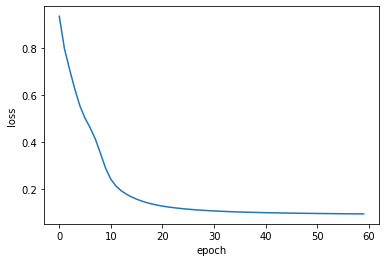

In [27]:
plt.plot(np.arange(epochs), loss_values)
plt.xlabel('epoch')
plt.ylabel('loss')

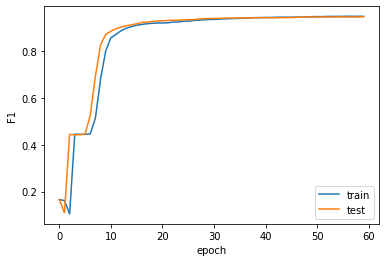

In [28]:
plt.plot(np.arange(epochs), F1_values_train, label='train')
plt.plot(np.arange(epochs), F1_values_test, label='test')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend()